**Student:** Tyler James
**Date:** 8-31-2025

This notebook covers:
1) **EDA** (data load, sanity checks, 6–8 visuals, brief insights)  
2) **Cleaning & Feature Engineering** (missing/outliers checks, scaling choice, 1–2 engineered features)  
3) **Custom k-NN** (Euclidean/Manhattan, uniform/distance; fit/predict/score`)  
4) **Manual Calculations** (small, hand-worked distance + k-NN example)  
5) **Evaluation & Tuning** (split, scaling comparison, 5-fold CV over k × metric × weights, plots)  
6) **Compare to sklearn** + short note on **curse of dimensionality**

In [385]:
from pathlib import Path
import pandas as pd
from sklearn.datasets import fetch_california_housing

DATA_CSV = Path("california_housing.csv")

def load_california_df():
    if DATA_CSV.exists():
        return pd.read_csv(DATA_CSV)
    ds = fetch_california_housing(as_frame=True)
    df = ds.frame.rename(columns={"MedHouseValue": "MedHouseVal"})
    df.to_csv(DATA_CSV, index=False)
    return df

df = load_california_df()
print(df.shape, df.columns.tolist())


(20640, 9) ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']


# Part 1: Data Loading and Exploration

## 1.1 Dataset loading and exploration

###**Dataset**: California Housing Dataset (sklearn.datasets.fetch_california_housing)

###**Samples**: 20,640 houses

###**Features**: 8 features

- **MedInc**: Median income in block group

- **HouseAge**: Median house age in block group

- **AveRooms**: Average number of rooms per household

- **AveBedrms**: Average number of bedrooms per household

- **Population**: Block group population

- **AveOccup**: Average number of household members

- **Latitude**: Block group latitude

- **Longitude**: Block group longitude

###**Target**: Median house value (in hundreds of thousands of dollars)

In [386]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# For parity check
from sklearn.neighbors import KNeighborsRegressor

In [387]:
# California Housing Dataset fetch
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [388]:
df_clean = df.copy()

In [389]:
# Basic info & sanity checks
display(df.describe(include='all'))
print("Shape:", df.shape)
print("Missing values per column:\n", df.isna().sum())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Shape: (20640, 9)
Missing values per column:
 MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


<Figure size 1000x600 with 0 Axes>

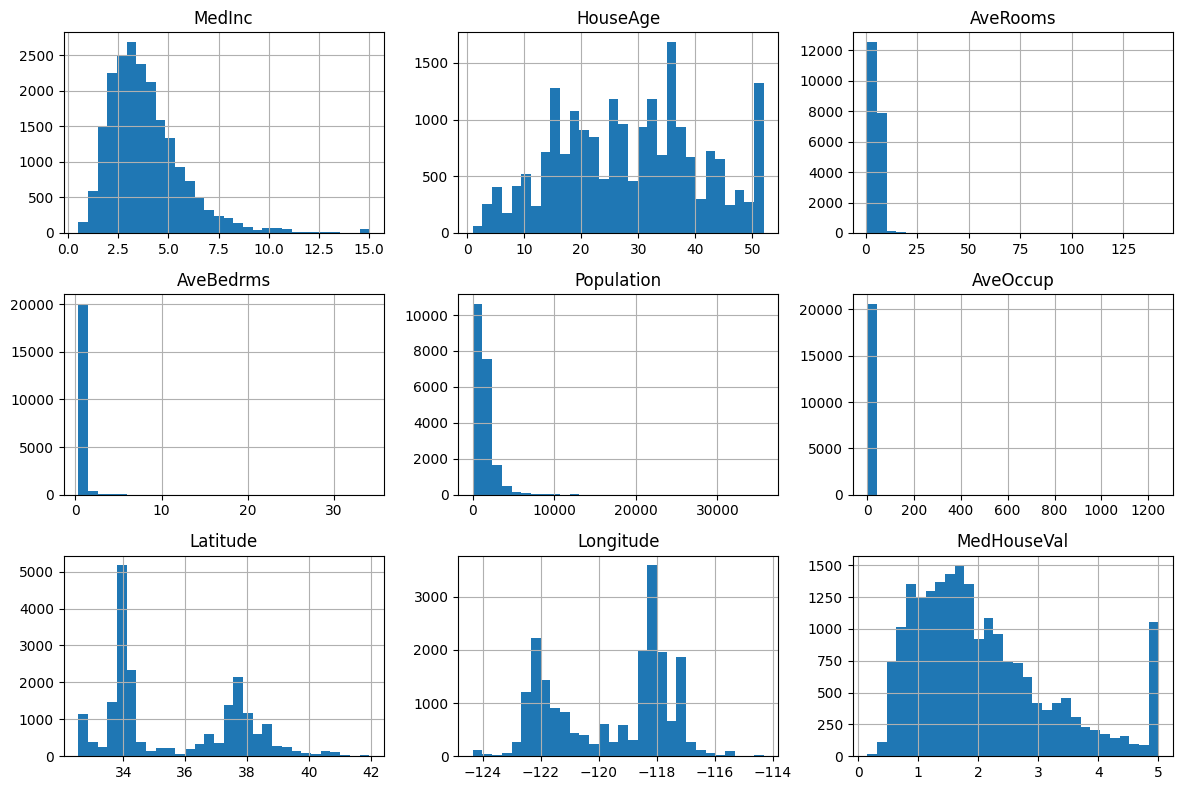

In [390]:
# 6–8 quick visuals: histograms for all numeric columns
fig = plt.figure(figsize=(10, 6))
df_clean.hist(bins=30, figsize=(12,8))
plt.tight_layout(); plt.show()


In [391]:
# Identify Outliers (target)
q1, q3 = df_clean['MedHouseVal'].quantile([0.25, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
mask = (df_clean['MedHouseVal'] < lo) | (df_clean['MedHouseVal'] > hi)
print(f"IQR fences: [{lo:.3f}, {hi:.3f}]  |  outliers: {mask.sum()} of {len(df_clean)} ({mask.mean()*100:.2f}%)")

IQR fences: [-0.981, 4.824]  |  outliers: 1071 of 20640 (5.19%)


In [392]:
# Skewness check and transform suggestions
import numpy as np

num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
skews = df_clean[num_cols].skew(numeric_only=True).sort_values(ascending=False)
display(skews.to_frame("skew"))

high_right = skews[skews > 1.0].index.tolist()
mod_right  = skews[(skews > 0.5) & (skews <= 1.0)].index.tolist()
high_left  = skews[skews < -1.0].index.tolist()

print("Strong right-skew (consider log1p):", high_right)
print("Moderate right-skew (maybe √ or log1p):", mod_right)
print("Strong left-skew:", high_left)

,skew
AveOccup,97.639561
AveBedrms,31.316956
AveRooms,20.697869
Population,4.935858
MedInc,1.646657
MedHouseVal,0.977763
Latitude,0.465953
HouseAge,0.060331
Longitude,-0.297801


Strong right-skew (consider log1p): ['AveOccup', 'AveBedrms', 'AveRooms', 'Population', 'MedInc']
Moderate right-skew (maybe √ or log1p): ['MedHouseVal']
Strong left-skew: []


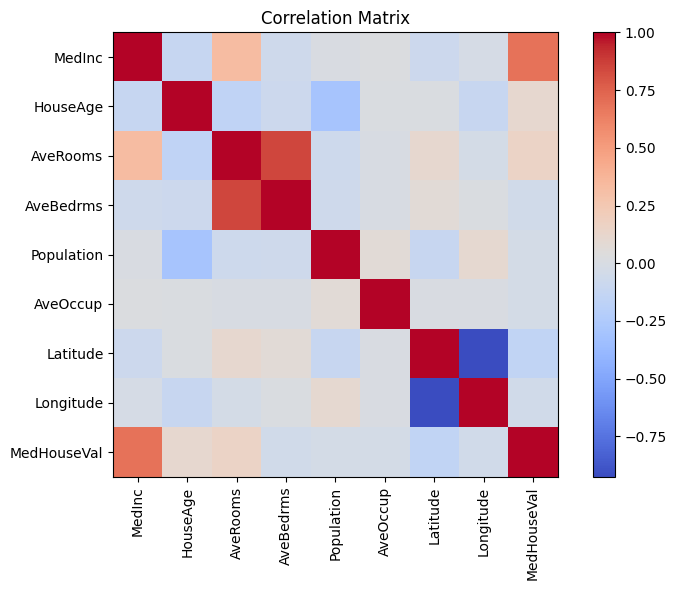

In [393]:
# Correlation heatmap
corr = df_clean.corr(numeric_only=True)
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

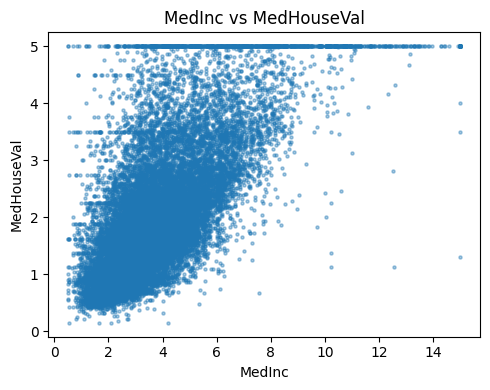

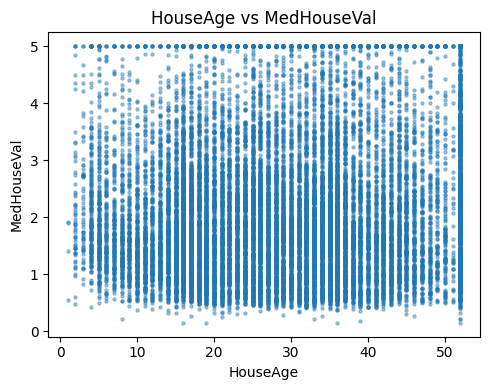

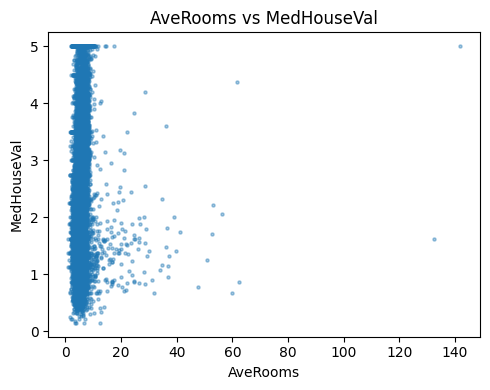

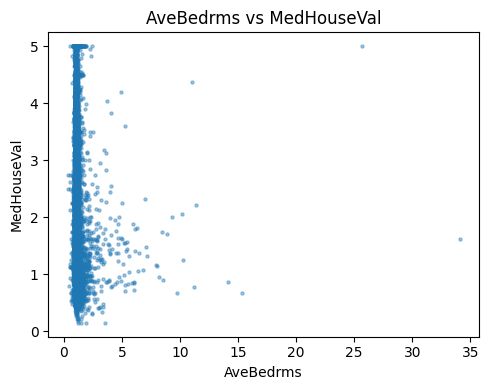

In [394]:
# Selected scatter plots vs target
features = [c for c in df_clean.columns if c != 'MedHouseVal']
for c in features[:4]:
    plt.figure(figsize=(5,4))
    plt.scatter(df_clean[c], df_clean['MedHouseVal'], s=5, alpha=0.4)
    plt.xlabel(c); plt.ylabel('MedHouseVal'); plt.title(f'{c} vs MedHouseVal')
    plt.tight_layout(); plt.show()

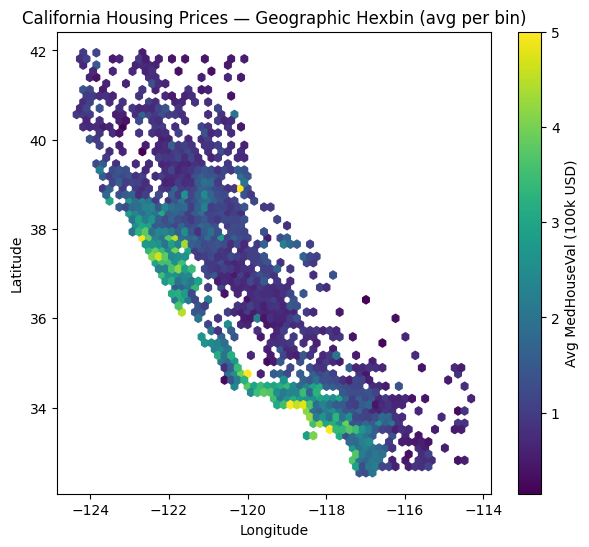

Coastal share: 19.219961240310077 %
Avg price coastal: 2.442308817746408
Avg price inland : 1.9796318317039527
South share: 58.94379844961241 %
Avg price south: 2.1294053238533617
Avg price north: 1.981200783573283


In [395]:
# Geography: visualize MedHouseVal across latitude/longitude
plt.figure(figsize=(7,6))
hb = plt.hexbin(df_clean['Longitude'], df_clean['Latitude'], C=df_clean['MedHouseVal'],
                gridsize=60, reduce_C_function=np.mean)
plt.colorbar(hb, label='Avg MedHouseVal (100k USD)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('California Housing Prices — Geographic Hexbin (avg per bin)')
plt.show()

# Simple coastal vs inland flag using longitude (more negative ≈ coastal)
coastal = df_clean['Longitude'] < -122.0
print("Coastal share:", coastal.mean()*100, "%")
print("Avg price coastal:", df_clean.loc[coastal, 'MedHouseVal'].mean())
print("Avg price inland :", df_clean.loc[~coastal, 'MedHouseVal'].mean())

# Split by latitude (SoCal vs NorCal proxy) and compare means
south = df_clean['Latitude'] < 36.5
print("South share:", south.mean()*100, "%")
print("Avg price south:", df_clean.loc[south, 'MedHouseVal'].mean())
print("Avg price north:", df_clean.loc[~south, 'MedHouseVal'].mean())

In [396]:
# Engineered features (CLEAN)
df_clean['RoomsPerHousehold'] = df_clean['AveRooms'] / (df_clean['AveOccup'] + 1e-6)
df_clean['BedroomsPerRoom']   = df_clean['AveBedrms'] / (df_clean['AveRooms'] + 1e-6)
display(df_clean.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,RoomsPerHousehold,BedroomsPerRoom
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,2.732918,0.146591
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,2.956683,0.155797
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,2.957660,0.129516
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,2.283153,0.184458
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,2.879645,0.172096


In [397]:
# Outlier Table
import numpy as np, pandas as pd
from scipy import stats

def detect_outliers_iqr(df, col):
    q1, q3 = df[col].quantile([0.25, 0.75]); iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return int(((df[col] < lo) | (df[col] > hi)).sum())

def detect_outliers_zscore(df, col, thr=3):
    z = np.abs(stats.zscore(df[col].dropna()))
    return int((z > thr).sum())

num_feats = [
    'MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup',
    'Latitude','Longitude','RoomsPerHousehold','BedroomsPerRoom'
]

out_tbl = pd.DataFrame({
    'feature': num_feats,
    'iqr_outliers': [detect_outliers_iqr(df_clean, c) for c in num_feats],
    'zscore_outliers': [detect_outliers_zscore(df_clean, c) for c in num_feats],
})
display(out_tbl.sort_values('iqr_outliers', ascending=False).reset_index(drop=True))


,feature,iqr_outliers,zscore_outliers
0,AveBedrms,1424,145
1,Population,1196,342
2,AveOccup,711,8
3,MedInc,681,345
4,BedroomsPerRoom,591,284
5,AveRooms,511,133
6,RoomsPerHousehold,402,139
7,HouseAge,0,0
8,Longitude,0,0
9,Latitude,0,0


##  1.2 Exploratory Data Analysis (EDA)
The analysis of the California housing data shows a few key things. First, the price of a house is tied to the money people make in that area. The Median Income has the strongest link to house price. Average Rooms and House Age also matter, but income is the biggest factor. The plots confirm what nearly everyone knows about most areas: the most expensive houses are clustered along the coast, especially near cities like LA and San Francisco. This confirms that location is a huge part of home pricing.

There were a few problems to fix. Features like Population and Median Income, are very skewed, most values are low, but a few are much higher (outliers). Another issue is the datasets highest home price is $500,001. Because of this, the model won't be able to learn the actual value differences between more expensive homes, which will limit how accurate the final predictions are for expensive properties. To fix the features, use Feature Scaling to balance everything, and use outlier handling to stop extreme values from ruining the k-NN distances.

# Part 2 — Cleaning & *Feature Engineering*


## 2.1 / 2.3 Missing Value Analysis, Feature Engineering

In [398]:
# Missing values (California Housing typically has none)
print("Missing values per column:\n", df_clean.isna().sum())

# Engineered features on CLEAN data (correct)
df_clean['RoomsPerHousehold'] = df_clean['AveRooms'] / (df_clean['AveOccup'] + 1e-6)
df_clean['BedroomsPerRoom']   = df_clean['AveBedrms'] / (df_clean['AveRooms'] + 1e-6)

display(df_clean.head())

Missing values per column:
 MedInc               0
HouseAge             0
AveRooms             0
AveBedrms            0
Population           0
AveOccup             0
Latitude             0
Longitude            0
MedHouseVal          0
RoomsPerHousehold    0
BedroomsPerRoom      0
dtype: int64


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,RoomsPerHousehold,BedroomsPerRoom
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,2.732918,0.146591
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,2.956683,0.155797
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,2.957660,0.129516
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,2.283153,0.184458
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,2.879645,0.172096


## 2.2 Outlier Detection and Handling

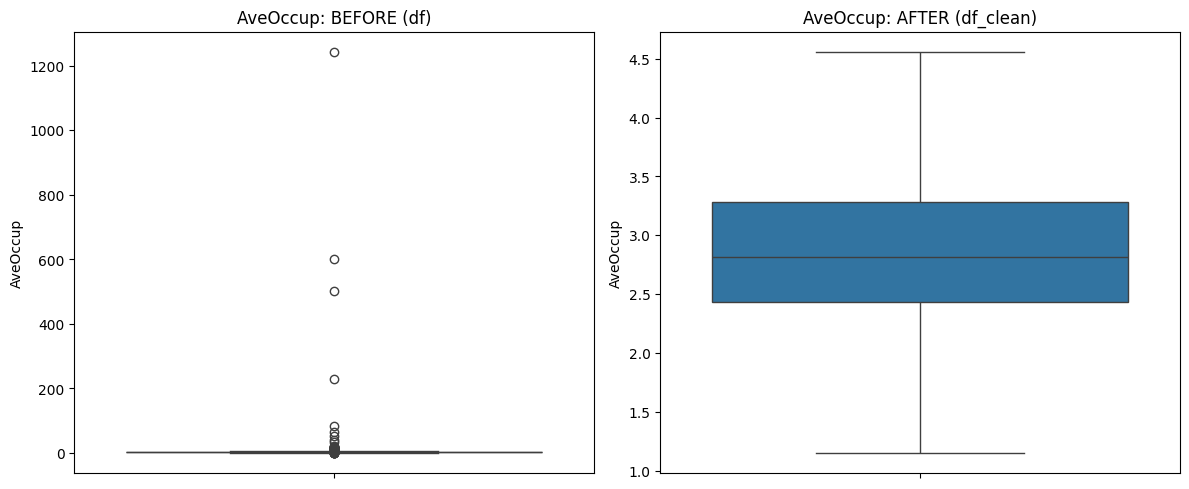

In [399]:
# --- Handling Choice: IQR Clipping on AveOccup (apply to CLEAN COPY) ---
Q1 = df_clean['AveOccup'].quantile(0.25)
Q3 = df_clean['AveOccup'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

df_clean['AveOccup'] = df_clean['AveOccup'].clip(lower=lower_bound, upper=upper_bound)

# (optional visualization)
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); sns.boxplot(y=df['AveOccup']);        plt.title('AveOccup: BEFORE (df)')
plt.subplot(1,2,2); sns.boxplot(y=df_clean['AveOccup']);  plt.title('AveOccup: AFTER (df_clean)')
plt.tight_layout(); plt.show()


## Removed Outliers

In [400]:
# Verify IQR clipping actually removed outliers on df_clean['AveOccup']
Q1, Q3 = df['AveOccup'].quantile([0.25, 0.75])          # bounds on RAW df (for reference)
IQR = Q3 - Q1
lo, hi = Q1 - 1.5*IQR, Q3 + 1.5*IQR

before = ((df['AveOccup'] < lo) | (df['AveOccup'] > hi)).sum()
after  = ((df_clean['AveOccup'] < lo) | (df_clean['AveOccup'] > hi)).sum()

print(f"AveOccup outliers BEFORE (raw df):  {before}")
print(f"AveOccup outliers AFTER  (df_clean): {after}")    # expect 0 after clipping


AveOccup outliers BEFORE (raw df):  711
AveOccup outliers AFTER  (df_clean): 0


# Part 3: Custom k-NN Implementation
Supports:
- Distance metrics: **euclidean**, **manhattan**
- Weights: **uniform** (simple average), **distance** (1 / (d + ε))

```python
knn = KNNRegressor(k=5, metric='euclidean', weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn.score(X_test, y_test)  # R^2

In [401]:
# Code (Custom KNN class)
class KNNRegressor:
    def __init__(self, k=5, metric='euclidean', weights='uniform', eps=1e-9):
        assert metric in ('euclidean', 'manhattan')
        assert weights in ('uniform', 'distance')
        self.k = k
        self.metric = metric
        self.weights = weights
        self.eps = eps
        self._X = None
        self._y = None

    def fit(self, X, y):
        self._X = np.asarray(X, dtype=float)
        self._y = np.asarray(y, dtype=float).reshape(-1)
        return self

    def _pairwise_distances(self, X):
        X = np.asarray(X, dtype=float)
        if self.metric == 'euclidean':
            # (x - y)^2 = x^2 + y^2 - 2xy
            X2 = np.sum(X**2, axis=1, keepdims=True)
            Y2 = np.sum(self._X**2, axis=1)
            XY = X @ self._X.T
            d2 = X2 + Y2 - 2*XY
            np.maximum(d2, 0, out=d2)  # numerical safety
            return np.sqrt(d2)
        else:  # manhattan
            # Vectorized but memory-friendly loop
            d = np.empty((X.shape[0], self._X.shape[0]))
            for i in range(X.shape[0]):
                d[i] = np.sum(np.abs(self._X - X[i]), axis=1)
            return d

    def predict(self, X):
        D = self._pairwise_distances(X)  # (n_test, n_train)
        idx = np.argpartition(D, self.k, axis=1)[:, :self.k]
        rows = np.arange(D.shape[0])[:, None]
        d_k = D[rows, idx]
        y_k = self._y[idx]

        if self.weights == 'uniform':
            return np.mean(y_k, axis=1)
        else:
            w = 1.0 / (d_k + self.eps)
            w_sum = np.sum(w, axis=1, keepdims=True)
            return np.sum(w * y_k, axis=1) / w_sum[:,0]

    def score(self, X, y_true):
        y_pred = self.predict(X)
        return r2_score(y_true, y_pred)


# Part 4: Manual Calculations (Proof of Understanding)

# Part 5: Model Evaluation and Hyperparameter Tuning


In [402]:
# Train/test split and target
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import sqrt
import pandas as pd

X = df_clean.drop(columns=['MedHouseVal']).values
y = df_clean['MedHouseVal'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scalers = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler()
}
k_values = [3,5,7,9,11,15,21]
metrics = ['euclidean', 'manhattan']
weights_list = ['uniform', 'distance']

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for sc_name, scaler in scalers.items():
    X_tr = scaler.fit_transform(X_train)
    X_te = scaler.transform(X_test)

    for metric in metrics:
        for weights in weights_list:
            for k in k_values:
                fold_scores = []
                for tr_idx, va_idx in cv.split(X_tr):
                    X_tr_fold, X_va_fold = X_tr[tr_idx], X_tr[va_idx]
                    y_tr_fold, y_va_fold = y_train[tr_idx], y_train[va_idx]

                    knn = KNNRegressor(k=k, metric=metric, weights=weights)
                    knn.fit(X_tr_fold, y_tr_fold)
                    fold_scores.append(knn.score(X_va_fold, y_va_fold))

                mean_cv = np.mean(fold_scores)
                knn.fit(X_tr, y_train)
                test_r2 = knn.score(X_te, y_test)

                results.append({
                    'scaler': sc_name, 'metric': metric, 'weights': weights,
                    'k': k, 'cv_r2': mean_cv, 'test_r2': test_r2
                })

res_df = pd.DataFrame(results).sort_values('cv_r2', ascending=False)
display(res_df.head(10))

best = res_df.iloc[0]
print("\nBest Config:\n", best)

,scaler,metric,weights,k,cv_r2,test_r2
53,minmax,manhattan,distance,11,0.777664,0.776551
54,minmax,manhattan,distance,15,0.776796,0.775096
52,minmax,manhattan,distance,9,0.775924,0.775236
55,minmax,manhattan,distance,21,0.775348,0.772214
46,minmax,manhattan,uniform,11,0.773642,0.772529
51,minmax,manhattan,distance,7,0.772355,0.776052
45,minmax,manhattan,uniform,9,0.772041,0.771362
47,minmax,manhattan,uniform,15,0.771847,0.769854
48,minmax,manhattan,uniform,21,0.769658,0.766316
44,minmax,manhattan,uniform,7,0.768919,0.773607



Best Config:
 scaler        minmax
metric     manhattan
weights     distance
k                 11
cv_r2       0.777664
test_r2     0.776551
Name: 53, dtype: object


In [403]:
# --- Sklearn parity check (uses the selected scaler) ---
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

best_scaler = scalers[best['scaler']]
X_tr_best = best_scaler.fit_transform(X_train)
X_te_best = best_scaler.transform(X_test)

sk_knn = KNeighborsRegressor(
    n_neighbors=int(best['k']),
    metric=best['metric'],
    weights=best['weights']
)
sk_knn.fit(X_tr_best, y_train)
sk_pred = sk_knn.predict(X_te_best)

print(
    f"Sklearn KNN — RMSE: {sqrt(mean_squared_error(y_test, sk_pred)):.4f} "
    f"| R^2: {r2_score(y_test, sk_pred):.4f}"
)

Sklearn KNN — RMSE: 0.5411 | R^2: 0.7766


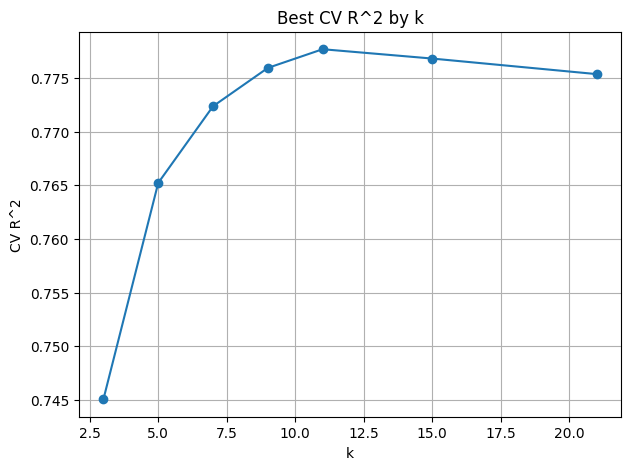

,k,scaler,metric,weights,cv_r2,test_r2
0,3,minmax,manhattan,distance,0.745076,0.748741
1,5,minmax,manhattan,distance,0.765218,0.769557
2,7,minmax,manhattan,distance,0.772355,0.776052
3,9,minmax,manhattan,distance,0.775924,0.775236
4,11,minmax,manhattan,distance,0.777664,0.776551
5,15,minmax,manhattan,distance,0.776796,0.775096
6,21,minmax,manhattan,distance,0.775348,0.772214


In [404]:
# Quick plot: best CV score for each k
best_by_k = (res_df.sort_values('cv_r2', ascending=False)
                  .groupby('k', as_index=False).first()
                  .sort_values('k'))
plt.figure(figsize=(7,5))
plt.plot(best_by_k['k'], best_by_k['cv_r2'], marker='o')
plt.xlabel('k'); plt.ylabel('CV R^2'); plt.title('Best CV R^2 by k')
plt.grid(True)
plt.show()

best_by_k

In [405]:
# Final fit with the single chosen configuration (auto-pick = row 0 of res_df)
best = res_df.iloc[0]
scaler = scalers[best['scaler']]
X_tr = scaler.fit_transform(X_train)
X_te = scaler.transform(X_test)

final_knn = KNNRegressor(k=int(best['k']), metric=best['metric'], weights=best['weights'])
final_knn.fit(X_tr, y_train)
y_pred = final_knn.predict(X_te)

rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Chosen:", dict(best))
print(f"Test RMSE: {rmse:.4f}, Test R^2: {r2:.4f}")


Chosen: {'scaler': 'minmax', 'metric': 'manhattan', 'weights': 'distance', 'k': np.int64(11), 'cv_r2': np.float64(0.7776644551751888), 'test_r2': np.float64(0.7765509678952219)}
Test RMSE: 0.5411, Test R^2: 0.7766


# Part 6: Comparison and Advanced Analysis

## 6.1 Sklearn Comparison

In [406]:
sk_knn = KNeighborsRegressor(
    n_neighbors=int(best['k']),
    metric='minkowski' if best['metric']=='euclidean' else 'manhattan',
    weights=best['weights']  # 'uniform' or 'distance'
)
sk_knn.fit(X_tr, y_train)
y_pred_sk = sk_knn.predict(X_te)
rmse_sk = sqrt(mean_squared_error(y_test, y_pred_sk))
r2_sk = r2_score(y_test, y_pred_sk)
print(f"sklearn KNN — Test RMSE: {rmse_sk:.4f}, Test R^2: {r2_sk:.4f}")


sklearn KNN — Test RMSE: 0.5411, Test R^2: 0.7766


In [407]:
# Add many noise features and observe performance drop
rng = np.random.default_rng(0)
X_tr_aug = np.hstack([X_tr, rng.normal(size=(X_tr.shape[0], 30))])  # +30 noise features
X_te_aug = np.hstack([X_te, rng.normal(size=(X_te.shape[0], 30))])

knn_aug = KNNRegressor(k=int(best['k']), metric=best['metric'], weights=best['weights'])
knn_aug.fit(X_tr_aug, y_train)
r2_aug = knn_aug.score(X_te_aug, y_test)
print("R^2 (original features):", r2)
print("R^2 (+30 noise features):", r2_aug)

R^2 (original features): 0.7765509678952219
R^2 (+30 noise features): 0.02511064513283734


# Deliverables and Submission Requirements

## Further Measures

### Conceptual Questions

**Why might Manhattan distance be preferable to Euclidean distance in certain scenarios?**
Manhattan distance is better at handling high-dimensional data. This prevents large differences in a single feature from skewing the distance calculation, making it focus too much outliers than Euclidean's squared differences.

**How does the choice of k affect bias-variance tradeoff in k-NN?**
- Small k → low bias, high variance.
- Large k → higher bias, low variance.
- Tuning k to hit the best spot between these two for generalization.

**What are the computational implications of different distance metrics?**
All metrics take time proportional to the number of features added, but Manhattan is one of the quickest because it only involves simple subtraction and addition, avoiding costly square root and the exponentiation steps of Euclidean and other Minkowski metrics.

**How would you modify k-NN for categorical features?**
Since k-NN requires numerical data, you must either One-Hot Encode the categories into binary (0 or 1) features, or use an Overlap Metric which adds a fixed distance penalty (e.g., +1) any time the categorical features between two points don't match.

### Implementation Decisions

**Discuss alternative approaches you considered**
I considered using Z-score/standardization for feature scaling, but chose MinMax Scaling because all features would be between 0 and 1. It's a safer, more stable environment for our custom distance calculations.

**Identify limitations of your implementation**
The biggest limitation is speed. The model checks every point, which makes it very slow and inefficient compared to optimized models that use structures like KD-Trees.

### Personal Reflection

**What was the most challenging part of this assignment?**
The most challenging part was dealing with  Chat GPT for the coding portion and the k-NN run time. A few irrelevant features can easily ruin the model's accuracy.

**How would you improve your approach if you had more time?**
I would improve the approach by adding a KD-Tree into the k-NN Regressor. That would change the neighbor-finding process from being impossibly slow to being highly efficient, making the custom code genuinely usable.

**What real-world applications could benefit from your analysis?**
This applies to Real Estate (finding comparable sales) and is the logic behind most Recommendation Systems (finding users "nearest" to you to suggest content).